# Bayesian tensorflow processing network
In this example we accomplish a number of goals.
1. the creation of two  Processing Nodes
2. how to buffer data
3. How to train a model
4. how to draw predictions
5. how to retrieve results
6. model evaluation and accuracy

Overall, this example should illustrate how to migrate any machine learning approach into a real-time production algorithm that uses processing networks.

# 1 Creating Example Processing Nodes
Here LoadData and BatchRegressionNode are created. LoadData loads in data to be predicted. BatchRegressionNode learns a pattern from the data.

In [1]:
import sys
sys.path.append("/home/paxml-user/")

from processingNetwork.LinearFitNetwork import *
import pprint


# ---> LoadData ---> 
class LoadData(ProcessingNode):
    def do_init(self):
        pass
    def do_process(self,feature):
        feature_dict=feature[self.settings['input']].copy()
        #print('keys')
        #print(feature_dict.keys())
        #print('elevation')
        #print(feature_dict['elevation'])
        #print('latln')
        #print(feature_dict['latln'])
        #print('-------------')
        
        # These two lines accomplish the identical task. The second variable is not reccomended.
        self.setValue(feature_dict)
        self.set(key='',dictData=feature_dict)
        self.set(key='test',dictData="test_value")
        #print(feature)
        #['latln', 'elevation'])
        return feature


In [2]:

# Step 1: Basic training and regression
# Step 2: visualize information on a simple plot over time
# Step 3: 
    
class BatchRegressionNode(ProcessingNode):
    '''
    This class trains a BR model. It buffers runlengths of features and trains a model when it is ready.
    '''
    def do_init(self):
        self.regressor = None
        self.trainingFeature = []
        self.testingFeature = []
        self.pastFeatures = []
        try:
            self.countTrain = self.settings['trainCount']
            self.countTest = self.settings['testCount']
            self.xKey = self.settings['xKey']
            self.yKey = self.settings['yKey']
            self.predictionLength = self.settings['predictionLength']
            # TODO: generalize so the model can be configured from outside of the class.
        except:
            raise Exception("Could not access settings 'trainCount' and/or 'testCount' in BatchRegressionNode")
            
        self.rawFeatures = []
        self.modelIndex = 0
        pass
    
    def loadRawFeature(self,feature):
        dataIn = self.get_dependency_value(0)
        trainingData = dataIn[self.xKey]
        targetValues = dataIn[self.yKey]
        #TODO - Generalize so this supports all shapes of array.
        newFeature = np.append(trainingData,targetValues)
        self.rawFeatures.append(newFeature)
        #print ('adding features')
        #print(newFeature)
                    
    def normalizeArray(self,arr,mean,std):
        #print(arr)
        # This is very sketchy. Replace with a method to test for lists vs single elements
        try:
            l = len(arr)
            df = pd.DataFrame(arr)
            df = df-mean
            df = df/std
            x = np.array(df)
        except:
            x = arr-mean
            x = arr/std
        return x
    
    def unNormalizeArray(self,arr,mean,std):
        df = pd.DataFrame(arr)
        df = df*std
        df = df+mean
        x = np.array(df)
        return x
    
    def doTraining(self):
        #print(len(self.rawFeatures))
        if len(self.rawFeatures) > self.countTrain:
            self.pastFeatures = self.pastFeatures  + self.rawFeatures 
            self.rawFeatures = []
            #print(self.pastFeatures)
            dataSet = np.array(self.pastFeatures)
            #self.finishedFeatures = []
            #if (self.regressor == None):
            #print (dataSet[0])
            D = len(dataSet[0])-1 # tie the dimension to the length of the feature minus the predictor
            df = pd.DataFrame(dataSet )
            self.modelIndex = self.modelIndex + 1
            self.regressor = nd.BRNode({'dimensions':(D,1),'name':'thresholdFit' + str(self.modelIndex)})
            self.r_means = df.mean()
            self.r_stds = df.std()
            xt = []

            for i in range(0,D):
                arr = self.normalizeArray(df[i],self.r_means[i],self.r_stds[i])
                xt.append(arr)
                xt[i] = xt[i]
            
            xt = np.array(xt )
            xt = xt[:,:,0]
            xt = xt.transpose()
            #display(df)
            yt = self.normalizeArray(df[D],self.r_means[D],self.r_stds[D])
            yt = yt[:,0]
            yt = np.array(yt )

            print ('shape of training set:')
            print(np.shape(xt))
            print(np.shape(yt))
            

            self.regressor.train(xt,yt)
            self.regressor.criticise(xt,yt)
            #print('clearing features')
    

    def doPredict(self):
            if (self.regressor):
                dataIn = self.get_dependency_value(0)
                trainingData = dataIn[self.xKey]
                #targetValues = dataIn[self.yKey]
                xt = []

                #print ('shape of training set:')
                for i in range(0,len(trainingData)):
                    arr = self.normalizeArray(trainingData[i],self.r_means[i],self.r_stds[i])
                    xt.append(arr)
                    xt[i] = xt[i]
                xt = np.array(xt)
                
                
                
                p = self.regressor.predict(xt,self.predictionLength )
                #display(p)
                p = np.array(p)
                #print(p)
                if len(np.shape(p)) ==3:
                    p = pd.DataFrame(np.array(p)[:,:,0])
                else:
                    p = pd.DataFrame(np.array(p))
                    
                means = p.mean()
                stds = p.std()
                #print('Predict Results')
                #display(p)
                #print ('means',means)
                #print ('stds',stds)
                
                return [means,stds]
            return [0,0]                
                
    def do_process(self,feature):
        self.loadRawFeature(feature)
        self.doTraining()
        [means,stds] = self.doPredict()
        ym = 0
        ys = 0
        if len(self.pastFeatures) > 0:

            dataSet = np.array(self.pastFeatures)
            D = len(dataSet[0])-1 # tie the dimension to the length of the feature minus the predictor

            ym = self.unNormalizeArray(means,self.r_means[D],self.r_stds[D])
            ys = self.unNormalizeArray(stds,self.r_means[D],self.r_stds[D])

        #Set the mean value
        self.setValue({'means':ym,'stds':ys})
        return feature
    


In [3]:
def defaultNetwork(settings):
    purchaseDecisionNetwork_def = {}

    purchaseDecisionNetwork_def['loadData'] = {'name': 'loadData',
                          'type': LoadData,
                          'settings': {'input':'predict_features'},
                          'dependencies': []}
    
    purchaseDecisionNetwork_def['BatchRegressionNode'] = {'name': 'BatchRegressionNode',
                          'type': BatchRegressionNode,
                          'settings': {'trainCount':50,
                                       'testCount':100,
                                       'xKey':'latln',
                                       'yKey':'elevation',
                                       'predictionLength':5},
                          'dependencies': ['loadData']
                            }

    pn=ProcessingNetwork(purchaseDecisionNetwork_def)
    return  pn


In [4]:
# This builds a random dataset with a linear relationship underneath, governed by y= w*x + b
def build_toy_dataset(N, w, noise_std=0.01):
    D = len(w)
    x = np.random.randn(N, D)*5
    
    y = np.dot(x, w) 
    y = y  + np.random.normal(0, noise_std, size=N)
    return x, y



global streamingDataSet
global streamingY

def init(settings={}):
    global pn
    global streamingDataSet
    global streamingY
    print ('initing test dataset')
    pn = defaultNetwork(settings)
    streamingDataSet,streamingY = settings['training_data_function'](1500,[0.5,0.25])
    #display(streamingDataSet)
    #streamingDataSet = np.array(streamingDataSet)
    
global dataStore
dataStore = []
def run_step():
    global count
    global max_count
    global pn
    global streamingDataSet
    global streamingY
    global dataStore
    
    count = count +1
    index = count % len(streamingDataSet)
    
    sd = streamingDataSet
    sy = streamingY
    feature={'predict_features':{'latln':sd[index][0:2],'elevation':sy[index]}}
    feature = pn.process(feature)
    #pprint.pprint (feature)
    dataset = {}
    datainsert = {'lat':feature['predict_features']['latln'][0],
                  'lon':feature['predict_features']['latln'][1],
                  'elevation':feature['predict_features']['elevation'],
                  'mean':feature['BatchRegressionNode']['means'],
                  'std':feature['BatchRegressionNode']['stds'] }
    dataStore.append(datainsert)
    #print(datainsert)
    if count > max_count:
        print ("Finished",count, " > ", max_count)
        return 0
    return 1

def addLog(label,val):
    pass
def getLog(elems=slice(None,None)):
    pass


global pn 
global count
global max_count

pn = None
count = 0
max_count = 100


initing test dataset
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
initializing x-dim: 2
initializing y-dim: 1
shape of training set:
(51, 2)
(51,)
pre training size self.w,self.qw
(2,)
(2,)
pre training size self.b,self.qb
(1,)
(1,)
pre training size self.X,X (input)
(51, 2)
(51, 2)
pre training size self.Y,Y (input)
(51,)
(51,)


/home/ec2-user/anaconda3/envs/tensorflow/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


250/250 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 53.444
Define Visualize


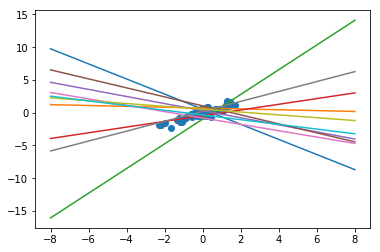

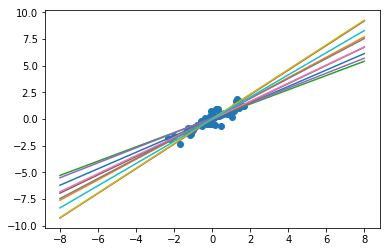

Define Visualize


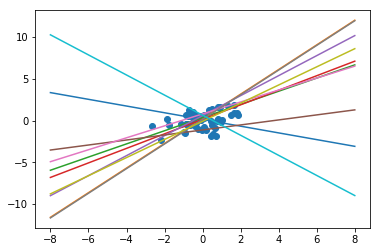

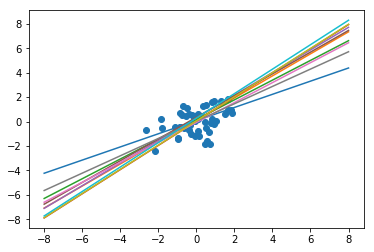

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
Finished 101  >  100


In [5]:

settings = {'training_data_function':build_toy_dataset}
init(settings)
i = 0
while run_step():
    i = i + 1
    print('.')
    #if i > 20:
    #    break



# The Model  becomes fit
It is possible to observe that, over time, as the network processes, that the model becomes progressivly more accurate at predicting the fluxuations. Several subjects are demonstrated:
1. graph based computation
2. objective orientation
3. usage of Edward, tensorflow
4. Normalization and the reverse
5. Drawing and estimating samples from bayesian distribution
6. stably stochastic data

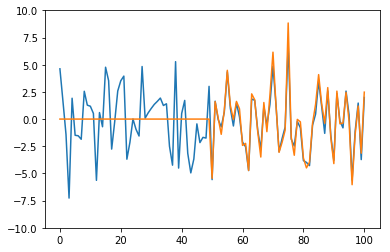

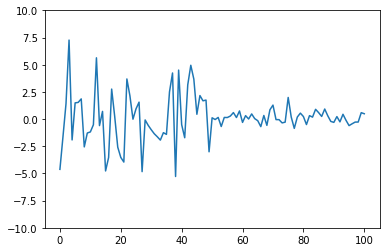

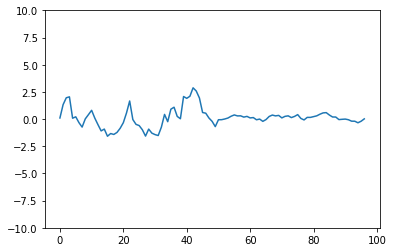

In [8]:
df = pd.DataFrame(dataStore)

diff = df['mean'] - df['elevation']
avg = np.convolve(diff, np.ones((5,))/5, mode='valid')

import matplotlib.pyplot as plt
plt.ylim((-10,10))
plt.plot(range(0,len(df['elevation'])),df['elevation'],df['mean'])
plt.show()

plt.ylim((-10,10))
plt.plot(range(0,len(df['elevation'])),diff)
plt.show()

plt.ylim((-10,10))
plt.plot(range(0,len(avg)),avg)
plt.show()